## Imports


In [78]:
import os
import matplotlib.pyplot as plt

import requests
import tarfile
import os

from tqdm import tqdm

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import models
from torch import nn


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definition of global constants

In [79]:
IMG_SIZE = (224,224)
IMAGE_PATH = os.path.join(os.getcwd(), 'dataset/images')

## Defining transformations

Defining transforms for images and labels. These are used for preprocessing each image used in the model

In [80]:
from torchvision import transforms
from torchvision.transforms import v2

from torchvision.models import ResNet34_Weights

# get transforms from resnet
weights = ResNet34_Weights.DEFAULT
resnet_preprocess = weights.transforms() # this is the preprocessing done by resnet34

# transforms used are those in https://pytorch.org/vision/stable/transforms.html example
train_transform = v2.Compose([
    # create random transform list
    v2.RandAugment()
])

val_transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Definition of training/testing loops

We now define the training/test functions as implemented in
https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [81]:
def train_loop(dataloader, model, loss_fn, optimizer, device, DEBUG=True, **kwargs):
    """
    Trains the model provided for one epoch.

    Returns:
        results : {
            'train_loss' : float, this is the average loss over the entire dataset,
            'train_accuracy' : float, this is the accuracy over the entire dataset
        }
    """
    print_every = int(kwargs.get('print_every', 10))
    data_aug = kwargs.get('data_aug', False)

    train_loss = 0
    train_accuracy = 0

    num_batches = len(dataloader)
    model.train()
    model.to(device)


    with tqdm(total=num_batches, dynamic_ncols=True) as pbar:
        for batch, (X, y) in enumerate(dataloader):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)

            #if data_aug:
            #    X = train_transform(X)

            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()

            # update loss and accuracy
            train_loss += loss.item()
            train_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

            if DEBUG and batch % print_every == 0:
                loss_item = loss.item()
                pbar.set_description(f"loss: {loss_item:>7f}  Batch:[{batch+1:>5d}/{num_batches:>5d}]")
            pbar.update(1)

    train_loss /= num_batches
    train_accuracy /= len(dataloader.dataset)
    return {
        'train_loss' : train_loss,
        'train_accuracy' : train_accuracy
    }

In [82]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {'validation_loss': test_loss, 'validation_acc': correct}

In [83]:
def evaluate_model(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    return accuracy, test_loss

## We create a function that creates the datasets and loads the data

Transform from category to binary classification

In [84]:
def BREED_TO_BINARY(label):
    """
    Takes a breed label 0-36 and converts it into 0/1 (cat or dog)
    """
    BREED_TO_BINARY = {}
    import re
    pattern = r'^[A-Za-z0-9_]+\s+\d+\s+\d+\s+\d+$'
    # Function to check if a line is valid
    def is_valid_line(line):
        return re.match(pattern, line) is not None

    filename = 'dataset/oxford-iiit-pet/annotations/list.txt'
    # create dict from list.txt
    with open(filename, 'r') as file:

        # Read each line in the file
        for line in file:
            # use regex
            if is_valid_line(line):
                # Split the line into tokens
                tokens = line.split()
                
                # Extract the image name and attributes
                id = int(tokens[1]) - 1
                binary = int(tokens[2]) - 1
                BREED_TO_BINARY[id] = binary

    return BREED_TO_BINARY[label]
   

Function to load all the datasets (training, validation, test)

In [85]:
import random
from torch.utils.data import Subset
from torchvision.datasets import OxfordIIITPet

def load_data(**kwargs):
    transform = kwargs.get('transform', None)
    if transform is not None:
        training_transform = v2.Compose([
            resnet_preprocess,
            transform
        ])
    else:
        training_transform = resnet_preprocess
    training_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=training_transform, target_transform=BREED_TO_BINARY, download=True)
    validation_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=resnet_preprocess, target_transform=BREED_TO_BINARY, download=False)
    test_data = OxfordIIITPet(root='dataset', split='test', target_types='category', transform=resnet_preprocess, target_transform=BREED_TO_BINARY, download=False)

    # shuffle and split into validation and training
    indices = list(range(len(training_data)))
    random.seed(310)  # fix the seed
    random.shuffle(indices)

    train_size = int(0.8 * len(training_data))
    train_dataset_split = Subset(training_data, indices[:train_size])
    val_dataset_split = Subset(validation_data, indices[train_size:])

    return train_dataset_split, val_dataset_split, test_data

## Next we define the model

In [86]:
num_classes = 2


model = models.resnet34(weights='DEFAULT')

# Change the output layer
in_features = model.fc.in_features
#model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
model.fc = nn.Linear(in_features, num_classes, bias=True)

for param in model.parameters():
    param.requires_grad = False

# unfreeze fc layer
for param in model.fc.parameters():
    param.requires_grad = True

## Next we define the training function

In [87]:
def train_model(model, loss_fn, optimizer, train_dataloader, val_dataloader, **kwargs):
    """
    Args:
        **kwargs : {
            'epochs' : int,
            'device' : torch.device,
            'scheduler' : torch.scheduler,
            'data_aug' : bool
        }
    """
    epochs = kwargs.get('epochs', 5)
    device = kwargs.get('device', torch.device('cpu'))
    scheduler = kwargs.get('scheduler', None)

    training_results = []
    validation_results = []
    best_loss = 999
    counter = 0
    best_val_acc = 0

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_res = train_loop(train_dataloader, model, loss_fn, optimizer, **kwargs)
        if scheduler is not None:
            scheduler.step()
        val_res = test_loop(val_dataloader, model, loss_fn, device)

        # append data
        training_results.append(train_res)
        validation_results.append(val_res)

        if val_res['validation_loss'] < best_loss:
            best_loss = val_res['validation_loss']
            counter = 0
        else:
            counter += 1
        if val_res['validation_acc'] >= best_val_acc:
            best_val_acc = val_res['validation_acc']
            torch.save(model.state_dict(), 'best_binary_model.pth')
        # break if not improving for last 5 epochs
        if t > 5 and counter == 5:
            print("Early stopping!")
            break
    print("Training done!")

    return {'train_res': training_results, 'val_res': validation_results}

Function for creating a graph from training results

In [88]:
# make one graph for accuracy and one for loss
import seaborn as sns
# use style
sns.set_theme(style='whitegrid')

def create_graphs(results, filename):
    train_loss = [res['train_loss'] for res in results['train_res']]
    val_loss = [res['validation_loss'] for res in results['val_res']]

    train_acc = [res['train_accuracy'] for res in results['train_res']]

    val_acc = [res['validation_acc'] for res in results['val_res']]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.lineplot(x=range(1, len(train_loss)+1), y=train_loss, ax=ax[0], label='train_loss')
    sns.lineplot(x=range(1, len(val_loss)+1), y=val_loss, ax=ax[0], label='val_loss')

    sns.lineplot(x=range(1, len(train_acc)+1), y=train_acc, ax=ax[1], label='train_acc')
    sns.lineplot(x=range(1, len(val_acc)+1), y=val_acc, ax=ax[1], label='val_acc')

    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')

    plt.savefig(filename)


We train the network using said parameters, running the test-loop on the validation set for each epoch to see if the model improves

Epoch 1
-------------------------------


loss: 0.111607  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.13it/s]


Validation Error: 
 Accuracy: 98.0%, Avg loss: 0.070694 

Epoch 2
-------------------------------


loss: 0.078932  Batch:[   91/   92]: 100%|██████████| 92/92 [00:42<00:00,  2.14it/s]


Validation Error: 
 Accuracy: 98.6%, Avg loss: 0.049042 

Epoch 3
-------------------------------


loss: 0.083862  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.039113 

Epoch 4
-------------------------------


loss: 0.032142  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]


Validation Error: 
 Accuracy: 99.0%, Avg loss: 0.034818 

Epoch 5
-------------------------------


loss: 0.027970  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.032826 

Epoch 6
-------------------------------


loss: 0.046961  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.036892 

Epoch 7
-------------------------------


loss: 0.014524  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


Validation Error: 
 Accuracy: 98.5%, Avg loss: 0.032555 

Epoch 8
-------------------------------


loss: 0.057713  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


Validation Error: 
 Accuracy: 98.0%, Avg loss: 0.055225 

Epoch 9
-------------------------------


loss: 0.019494  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]


Validation Error: 
 Accuracy: 98.9%, Avg loss: 0.029709 

Epoch 10
-------------------------------


loss: 0.087403  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.028984 

Epoch 11
-------------------------------


loss: 0.002809  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]


Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.026613 

Epoch 12
-------------------------------


loss: 0.121815  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]


Validation Error: 
 Accuracy: 98.9%, Avg loss: 0.028218 

Epoch 13
-------------------------------


loss: 0.017378  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]


Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.027131 

Epoch 14
-------------------------------


loss: 0.028974  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.13it/s]


Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.026219 

Epoch 15
-------------------------------


loss: 0.004476  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.027063 

Epoch 16
-------------------------------


loss: 0.015711  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


Validation Error: 
 Accuracy: 98.6%, Avg loss: 0.030005 

Epoch 17
-------------------------------


loss: 0.002751  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


Validation Error: 
 Accuracy: 99.0%, Avg loss: 0.029054 

Epoch 18
-------------------------------


loss: 0.007374  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]


Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.026246 

Epoch 19
-------------------------------


loss: 0.055082  Batch:[   91/   92]: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]


Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.027541 

Early stopping!
Training done!
Test Accuracy: 99.18%


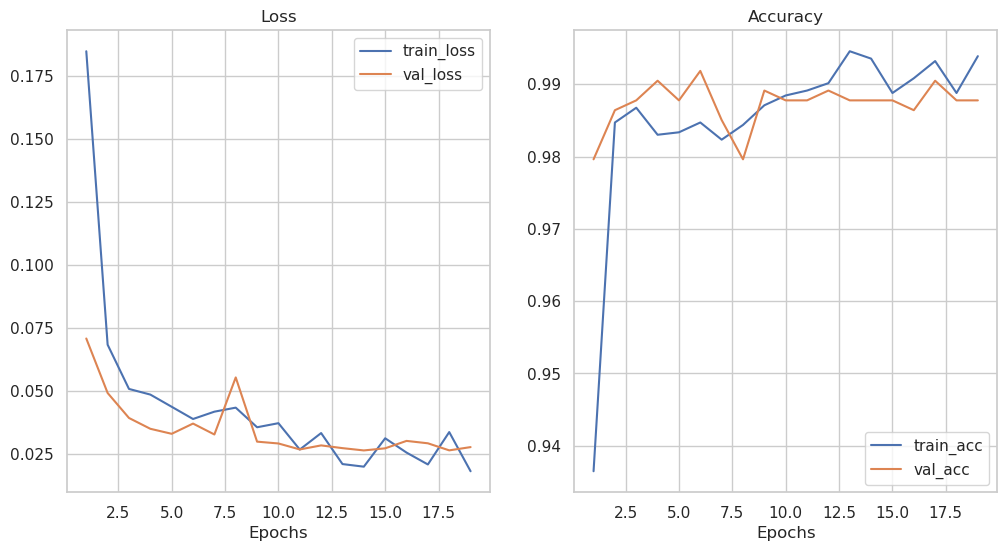

In [89]:
import csv

data_aug = False
batch_size = 32
_epochs = 25
lr = 0.001

# define the graph name
graph_name = f'graphs/binary_classification_{lr}.png'

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = None#torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Set up the data augmentation transformations if enabled
if data_aug:
    train_transform = v2.RandAugment()
else:
    train_transform = None

# Load the data
train_data, val_data, test_data = load_data(transform=train_transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=2)



# Train the model

results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader, epochs=_epochs, device=device, scheduler=scheduler,
            data_aug=data_aug)

# load the best model
model.load_state_dict(torch.load('best_binary_model.pth'))
# Evaluate the model on the validation set and get the accuracy
accuracy, test_loss = evaluate_model(test_dataloader, model, nn.CrossEntropyLoss(), device)

print(f"Test Accuracy: {accuracy:.2f}%")

# generate graphs and save them
filename = graph_name
create_graphs(results, filename)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

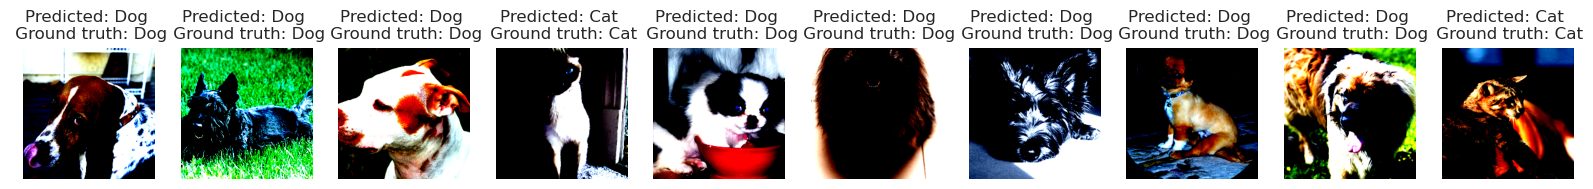

In [92]:
# show 10 images and the label that the model predicts
def visualize_model(model, num_images=10):
    label_to_pred = {'0': 'Cat', '1': 'Dog'}
    model.eval()
    
    fig, axs = plt.subplots(1, num_images, figsize=(20, 20))

    with torch.no_grad():
        for i in range(num_images):
            # randomize image to plot
            idx = random.randint(0, len(test_data))
            img, label = test_data[idx]
            pred = model(img.unsqueeze(0))
            pred_label = pred.argmax(1).item()
            axs[i].imshow(img.permute(1, 2, 0))
            axs[i].set_title(f"Predicted: {label_to_pred[str(pred_label)]} \n Ground truth: {label_to_pred[str(label)]}")
            axs[i].axis('off')
    plt.show()

visualize_model(model)

In [91]:
results

{'train_res': [{'train_loss': 0.184833403069364,
   'train_accuracy': 0.9364809782608695},
  {'train_loss': 0.06822220466869033, 'train_accuracy': 0.9847146739130435},
  {'train_loss': 0.050653050501790385, 'train_accuracy': 0.9867527173913043},
  {'train_loss': 0.048411176226142306, 'train_accuracy': 0.983016304347826},
  {'train_loss': 0.04356748694756433, 'train_accuracy': 0.9833559782608695},
  {'train_loss': 0.038709898648844304, 'train_accuracy': 0.9847146739130435},
  {'train_loss': 0.041618842294986316, 'train_accuracy': 0.9823369565217391},
  {'train_loss': 0.04322131538925612, 'train_accuracy': 0.984375},
  {'train_loss': 0.0354243271285668, 'train_accuracy': 0.9870923913043478},
  {'train_loss': 0.037043998836610546, 'train_accuracy': 0.9884510869565217},
  {'train_loss': 0.02657215798061098, 'train_accuracy': 0.9891304347826086},
  {'train_loss': 0.033120259385728074, 'train_accuracy': 0.9901494565217391},
  {'train_loss': 0.020799776670806434, 'train_accuracy': 0.994565217